# Cyclone Type Classification Project

Link to the data: https://www.kaggle.com/datasets/noaa/hurricane-database/data

About the data:
The National Hurricane Center (NHC) conducts a post-storm analysis of each tropical cyclone in the Atlantic basin (i.e., North Atlantic Ocean, Gulf of Mexico, and Caribbean Sea) and the North Pacific Ocean to determine the official assessment of the cyclone’s history. This analysis makes use of all available observations, including those that may not have been available in real time. In addition, NHC conducts ongoing reviews of any retrospective tropical cyclone analyses brought to its attention and on a regular basis updates the historical record to reflect changes introduced.

Goal: Classify the cyclones detected in the atlantic ocean.

## Importing Necessary Libraries

In [28]:
import pandas as pd
import seaborn as sns
import re
# import geopandas as gpd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Uploading the Dataset

In [29]:
data_atlantic = pd.read_csv('data/atlantic_corrupted.csv')
data_atlantic.head()

,Unnamed: 0,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,0,AL011851,UNNAMED,18510625.0,NaN,NaN,HU,28.0N,94.8W,80.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,-999.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,AL011851,UNNAMED,18510625.0,600.0,,HU,28.0N,95.4W,80.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,3,AL011851,UNNAMED,18510625.0,NaN,,HU,28.0N,96.0W,80.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,-999.0
4,4,AL011851,UNNAMED,18510625.0,1800.0,,HU,28.1N,96.5W,80.0,...,-999.0,-999.0,-999.0,NaN,-999.0,-999.0,-999.0,-999.0,NaN,-999.0


In [30]:
data_atlantic.shape

(49596, 23)

The data consists of over 49 thousand instances and 22 features + auxiliary feature 'Unnamed: 0' created by data_noiser.
We shall take a closer look and do the preprocessing step.

## Preprocessing

Firstly, we must understand what kind of information the dataset holds for each column.

In [31]:
data_atlantic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49596 entries, 0 to 49595
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        49596 non-null  int64  
 1   ID                49105 non-null  object 
 2   Name              49105 non-null  object 
 3   Date              49105 non-null  float64
 4   Time              27008 non-null  float64
 5   Event             35847 non-null  object 
 6   Status            49105 non-null  object 
 7   Latitude          49105 non-null  object 
 8   Longitude         49105 non-null  object 
 9   Maximum Wind      37811 non-null  float64
 10  Minimum Pressure  49105 non-null  float64
 11  Low Wind NE       34374 non-null  float64
 12  Low Wind SE       17187 non-null  float64
 13  Low Wind SW       49105 non-null  float64
 14  Low Wind NW       49105 non-null  float64
 15  Moderate Wind NE  49105 non-null  float64
 16  Moderate Wind SE  6923 non-null   float6

Asside from float and int objects, we also have some objects.

In [32]:
data_atlantic.describe(include='all')

,Unnamed: 0,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49596.000000,49105,49105,4.910500e+04,27008.000000,35847,49105,49105,49105,37811.000000,...,49105.000000,49105.000000,49105.000000,6923.000000,49105.000000,40267.000000,49105.000000,49105.000000,32410.000000,49105.000000
unique,NaN,1814,288,NaN,NaN,10,9,597,1036,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,AL031899,UNNAMED,NaN,NaN,,TS,28.0N,65.0W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,133,26563,NaN,NaN,35139,17804,299,181,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,24797.500000,NaN,NaN,1.949802e+07,911.993298,NaN,NaN,NaN,NaN,52.010156,...,-872.676428,-871.409245,-875.570940,-867.742019,-876.682028,-875.765143,-877.564321,-877.655045,-878.006788,-877.786295
std,14317.276312,NaN,NaN,4.461850e+05,669.847897,NaN,NaN,NaN,NaN,27.691329,...,342.153768,345.628984,333.651396,354.293936,330.526085,332.200213,328.027275,327.774794,326.938684,327.408253
min,0.000000,NaN,NaN,1.851062e+07,0.000000,NaN,NaN,NaN,NaN,-99.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,12398.750000,NaN,NaN,1.911110e+07,600.000000,NaN,NaN,NaN,NaN,35.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
50%,24797.500000,NaN,NaN,1.956093e+07,1200.000000,NaN,NaN,NaN,NaN,45.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
75%,37196.250000,NaN,NaN,1.989081e+07,1800.000000,NaN,NaN,NaN,NaN,70.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000


What we have is this:
- 'Unnamed: 0' column is just an ID column generated by data_noiser code. 
- 'Event', 'Status', 'Latitude', 'Longitude' are all non numerical features. 
- 'ID' and 'Name' are both strings. We shall remove the Name column and replace ID with numerical data.

We can just drop 'Unnamed: 0' column, or we can do this:

In [33]:
data_atlantic = data_atlantic.set_index('Unnamed: 0')

Now we shall evaluate how much data is missing for each feature.

In [34]:
data_atlantic.isnull().sum(axis=0) / data_atlantic.shape[0] * 100 # just for fun, let's see it in 'percentages'

ID                   0.989999
Name                 0.989999
Date                 0.989999
Time                45.543995
Event               27.721994
Status               0.989999
Latitude             0.989999
Longitude            0.989999
Maximum Wind        23.761997
Minimum Pressure     0.989999
Low Wind NE         30.691991
Low Wind SE         65.345996
Low Wind SW          0.989999
Low Wind NW          0.989999
Moderate Wind NE     0.989999
Moderate Wind SE    86.041213
Moderate Wind SW     0.989999
Moderate Wind NW    18.809985
High Wind NE         0.989999
High Wind SE         0.989999
High Wind SW        34.651988
High Wind NW         0.989999
dtype: float64

What we see is this:
- 'Time', 'Latitude', 'Maximum Wind', 'Low Wind NE', 'Low Wind SE', 'Moderate Wind NW', 'Moderate Wind SE' and 'High Wind SW' have moderately high percentage of missing data.
- The rest of the features have the same percentage of missing data, so we 'suspect' there are samples full of only missing data. Let's check:

In [35]:
# we check on axis=1, i.e. all the rows, for the instances full of only missing data by comparing the sum of missing values to the number of columns
print(f'Amount of samples containing only missing data: {(data_atlantic.isnull().sum(axis=1) == data_atlantic.shape[1]).sum()}')
print(f'The percentage of such rows: {((data_atlantic.isnull().sum(axis=1) == data_atlantic.shape[1]).sum())/data_atlantic.shape[0] * 100}')

Amount of samples containing only missing data: 491
The percentage of such rows: 0.9899991934833454


We have nearly 500 rows with missing data. This is less than 1% of total data, we can remove these rows.

In [36]:
data_atlantic.dropna(how='all', axis=0, inplace=True)
data_atlantic.shape

(49105, 22)

Now we go back to the features. 

In [37]:
data_atlantic.isnull().sum(axis=0) / data_atlantic.shape[0] * 100 # just for fun, let's see it in 'percentages'

ID                   0.000000
Name                 0.000000
Date                 0.000000
Time                44.999491
Event               26.999287
Status               0.000000
Latitude             0.000000
Longitude            0.000000
Maximum Wind        22.999695
Minimum Pressure     0.000000
Low Wind NE         29.998982
Low Wind SE         64.999491
Low Wind SW          0.000000
Low Wind NW          0.000000
Moderate Wind NE     0.000000
Moderate Wind SE    85.901639
Moderate Wind SW     0.000000
Moderate Wind NW    17.998167
High Wind NE         0.000000
High Wind SE         0.000000
High Wind SW        33.998574
High Wind NW         0.000000
dtype: float64

- Time has a float value here and missing values shall be substituted by median value.
- Event reflects a certain category of each cyclone. Missing values can be replaced by imputing the most frequent values.
- Latitude and Longitude here are object, but they can be transformed into numerical features. 
- Maximum Wind, Low Wind NE, Low Wind SE, Moderate Wind NW, High Wind SW, Moderate Wind SE are all numerical features, mean values will be imputed.

All right, we know what to do with missing values; now we have to understand how we should transform the features so that we can learn a good model.

First, we take a look at the target:

[' HU' ' TS' ' EX' ' TD' ' LO' ' DB' ' SD' ' SS' ' WV']
3


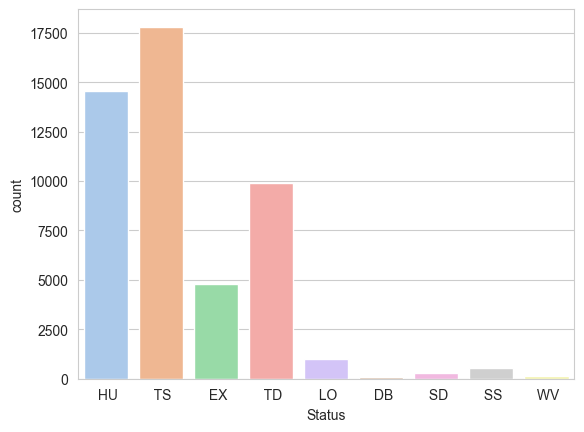

In [38]:
sns.countplot(x='Status', data=data_atlantic, palette='pastel')
print(data_atlantic.Status.unique())
print(len(data_atlantic.Status.unique()[0]))

Status can be the following types:
- TD – Tropical cyclone of tropical depression intensity (< 34 knots)
- TS – Tropical cyclone of tropical storm intensity (34-63 knots)
- HU – Tropical cyclone of hurricane intensity (> 64 knots)
- EX – Extratropical cyclone (of any intensity)
- SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
- SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
- LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
- WV – Tropical Wave (of any intensity)
- DB – Disturbance (of any intensity)

We can encode these categories by using OneHotEncoder, since the categories are nominal.

We take a look at the 'Event' now. 

In [45]:
data_atlantic.Event.unique()

array([nan, '  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T'],
      dtype=object)

In [43]:
class EventTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.str.strip()
        X = X.map({' ': 0, 'L': 1, 'C': 2, 'G': 3, 'I': 4, 'R': 5, 'P': 6, 'W': 7, 'S': 8, 'T': 9})
        # Fill any unmapped values with a default value, e.g., -1
        X = X.fillna(-1)
        return X

    def get_feature_names_out(self, input_features=None):
        return ['event_code']